####  Setup

In [1]:
import pandas as pd
import os
import math
import json
import matplotlib.pyplot as plt 
corpus_dir = 'corpus/'

In [2]:
corpus_files = os.listdir(corpus_dir) 
corpus_files = [file for file in corpus_files if file.endswith(".csv")]

In [11]:
corpus_files

['45.71.5.119_2023-10-31_Mujer_Derecha_33.csv',
 '38.122.7.210_2023-10-31_Mujer_Derecha_36.csv',
 '45.71.5.119_2023-11-01_Mujer_Derecha_26.csv',
 '45.71.5.119_2023-10-27_Hombre_Derecha_32.csv',
 '190.193.127.39_2023-10-20_Hombre_Derecha_24.csv',
 '190.194.167.208_2023-10-20_Mujer_Derecha_24.csv',
 '186.158.228.113_2023-10-26_Hombre_Derecha_18.csv',
 '201.234.41.210_2023-10-31_Hombre_Derecha_35.csv',
 '181.167.8.68_2023-10-25_Mujer_Derecha_33.csv',
 '201.231.237.246_2023-11-01_Hombre_Derecha_27.csv',
 '190.190.193.126_2023-11-01_Mujer_Derecha_26.csv',
 '190.188.115.65_2023-10-31_Mujer_Derecha_29.csv',
 '190.18.215.71_2023-10-19_Hombre_Derecha_23.csv',
 '186.13.97.33_2023-11-01_Mujer_Derecha_43.csv',
 '195.91.12.16_2023-10-25_Hombre_Derecha_33.csv',
 '186.141.199.210_2023-10-24_Mujer_Derecha_15.csv',
 '181.31.144.122_2023-10-31_Hombre_Izquierda_35.csv',
 '181.24.12.207_2023-10-21_Hombre_Derecha_25.csv',
 '157.92.14.67_2023-10-25_Mujer_Derecha_24.csv',
 '45.71.5.119_2023-10-24_Hombre_Dere

### Valid Responses Data

Contabilizamos para cada ejecución la cantidad de respuestas válidas por bloque.

Respuestas válidas != Respuestas correctas. Válidas para el tono: ["A", "S"] y para el número: ["J", "K"].

In [3]:
if not os.path.exists("metadata.csv"):
    df = pd.DataFrame(columns=["date", "gender", "hand", "age", "response_amount_block_1", "response_amount_block_2", "response_amount_block_3", "response_amount_block_4", "total_response_amount"])
    for file in corpus_files:
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file = file.split(".")[-2]
        date, gender, hand, age = file.split("_")[1:]
        gender = "woman" if gender == "Mujer" else "man"
        hand = "right" if hand == "Derecha" else "left"
        count_block = lambda block_number : sum(file_df['block'] == block_number)
        b1, b2, b3, b4 = count_block(0), count_block(1), count_block(2), count_block(3)
        df.loc[len(df.index)] = [date, gender, hand, int(age), 
                                    b1, b2, 
                                    b3, b4, 
                                    len(file_df)]

    df.to_csv("metadata.csv")
else:
    df = pd.read_csv("metadata.csv")

Text(0.5, 1.0, 'Gender')

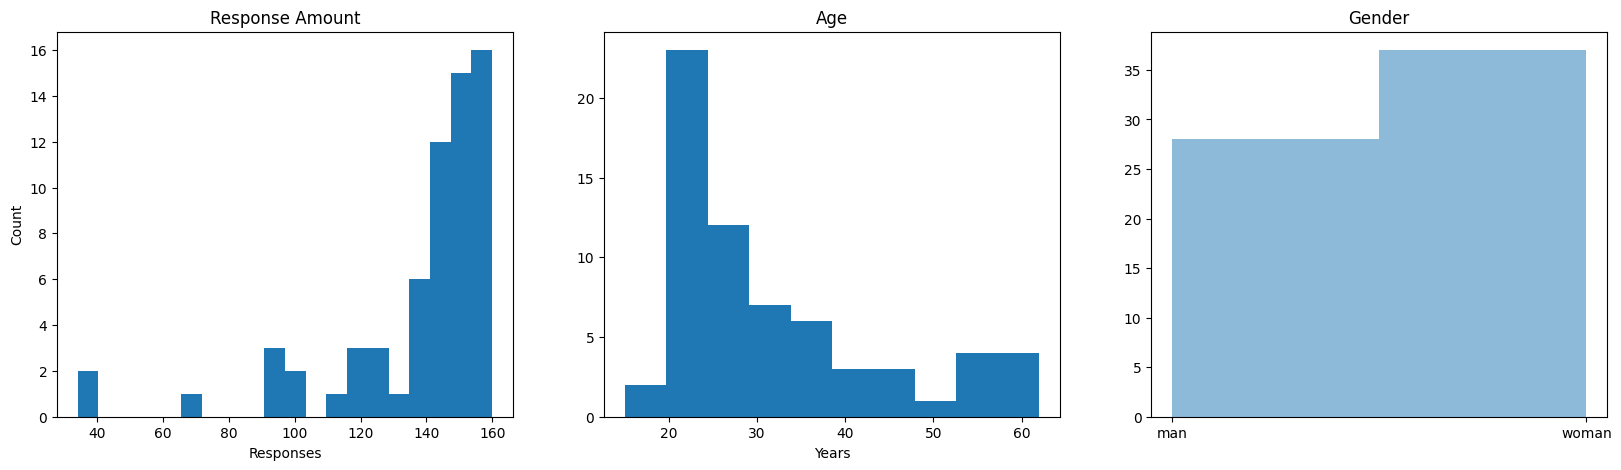

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].hist(df["total_response_amount"], bins=20)
axs[0].set_title("Response Amount")
axs[0].set_xlabel("Responses")
axs[0].set_ylabel("Count")
axs[1].hist(df["age"], bins=10)
axs[1].set_title("Age")
axs[1].set_xlabel("Years")
axs[2].hist(df["gender"], bins=2)
axs[2].set_title("Gender")

### Figuras del paper

## Figure 2 / Table 2. Effects of the Different Manipulations on the Mean and Dispersion of RT

A. Cambios en el promedio de RT de la tarea de números cuando el delay == 1025 para diferentes manipulaciones experimentales. Cambiar la notación hace al RT mas lento, y dentro de esa condición, las respuestas son mas lentas para distancias cortas que largas. La diferencia ente las condiciones de distancia cercana o lejana es independiente de la manipulación experimental.

B. A different pattern is observed for the interquartile range, which provides a measure of dispersion. While distance manipulation results in a
major change of the interquartile range, there is not a major effect of notation or response complexity.

In [13]:
# get DF (RT_digits_close, RT_digits_far, RT_words_close, RT_words_far) FOR ONLY delay == 1025
indexes = ["RT", "distance", "notation"]

mean_RT_delay_1025 = pd.DataFrame()
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df[file_df["delay"] == 1025]
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)

        mean_RT_delay_1025 = pd.concat([
            mean_RT_delay_1025,
            pd.concat([pd.DataFrame(file_df.groupby(["notation", "distance"]).rt_2.mean()),
            pd.DataFrame(file_df.groupby(["notation", "distance"]).rt_2_accum.mean())], axis=1).reset_index().rename(columns={"rt_2": "rt_2_mean", "rt_2_accum": "rt_2_accum_mean"}).set_index(["notation", "distance"])
            ], axis=0)
#mean_RT_delay_1025["file"] = corpus_files

In [14]:
mean_RT_delay_1025 = mean_RT_delay_1025.reset_index()

In [15]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [16]:
mean_RT_delay_1025

,notation,distance,rt_2_mean,rt_2_accum_mean
0,digit,close,629.250000,1654.250000
1,digit,far,669.400000,1694.400000
2,word,close,847.875000,1872.875000
3,word,far,725.750000,1750.750000
4,digit,close,734.900000,1759.900000
...,...,...,...,...
199,word,far,1404.100000,2429.100000
200,digit,close,577.000000,1602.000000
201,digit,far,503.444444,1528.444444
202,word,close,700.083333,1725.083333


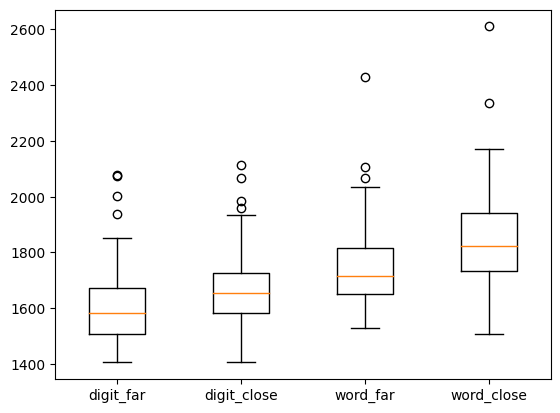

In [17]:
# plot a single figure with 4 bosplots (rt digit_close, rt digit_far, rt word_close, rt word_far)
filter_notation_distance = lambda n, d: mean_RT_delay_1025.loc[(mean_RT_delay_1025["notation"] == n) & (mean_RT_delay_1025["distance"] == d)]["rt_2_accum_mean"].values

digits_far = filter_notation_distance("digit", "far")
digits_close = filter_notation_distance("digit", "close")
words_far = filter_notation_distance("word", "far")
words_close = filter_notation_distance("word", "close")

plt.boxplot([digits_far, digits_close, words_far, words_close], labels=["digit_far", "digit_close", "word_far", "word_close"])
plt.show()


In [18]:
lm1 = ols("rt_2_mean ~ C(notation) + C(distance, Treatment('far'))", mean_RT_delay_1025).fit()
lm2 = ols("rt_2_mean ~ C(notation) : C(distance, Treatment('far'))", mean_RT_delay_1025).fit()
lm1_sum = lm1.summary()
lm_iteraction_sum = lm2.summary()


In [23]:
lm_iteraction_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rt_2_mean   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     19.27
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           5.13e-11
Time:                        17:24:49   Log-Likelihood:                -1332.0
No. Observations:                 204   AIC:                             2672.
Df Residuals:                     200   BIC:                             2685.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  593.1618     23.440     25.306      0.000     546.941     639.383
C(distance, Treatment('far'))[T.close]                      57.1749     33.149      1.725      0.086      -8.191     122.541
C(notation)[T.word]:C(distance, Treatment('far'))[close]   178.6060     33.149      5.388      0.000     113.240     243.972
C(notation)[T.word]:C(distance, Treatment('far'))[far]     142.4709     33.149      4.298      0.000      77.105     207.837
==============================================================================
Omnibus:                       61.175   Durbin-Watson:                   0.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.125
Skew:                           1.374   Prob(JB):                     6.16e-31
Kurtosis:                       5.970   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
table_1_df = pd.DataFrame(lm1_sum.tables[1].data)
table_1_df.columns = table_1_df.iloc[0]
table_1_df = table_1_df.drop(0)
table_1_df = table_1_df.set_index(table_1_df.columns[0])
table_1_df = table_1_df.rename(index={"C(distance, Treatment('far'))[T.close]": "C(distance)[T.close]"})

In [20]:
table_interaction_df = pd.DataFrame(lm_iteraction_sum.tables[1].data)
table_interaction_df.columns = table_interaction_df.iloc[0]
table_interaction_df = table_interaction_df.drop(0)
table_interaction_df = table_interaction_df.set_index(table_interaction_df.columns[0])
table_interaction_df = table_interaction_df.rename(index={"C(notation)[T.word]:C(distance, Treatment('far'))[close]": "C(notation)[T.word]:C(distance)[close]"})


In [22]:
results = pd.DataFrame(columns=["Task Manipulation", "Effect", "Mean", "Interquartile Range"])
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect", 
                                    f"F={table_1_df.loc['C(notation)[T.word]', 'coef'].strip()}, p={table_1_df.loc['C(notation)[T.word]', 'P>|t|'].strip()}", 
                                    f"F={table_1_df.loc['C(notation)[T.word]', 'coef'].strip()}, p={table_1_df.loc['C(notation)[T.word]', 'P>|t|'].strip()}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect of distance", 
                                    f"F={table_1_df.loc['C(distance)[T.close]', 'coef'].strip()}, p={table_1_df.loc['C(distance)[T.close]', 'P>|t|'].strip()}",
                                    f"F={table_1_df.loc['C(distance)[T.close]', 'coef'].strip()}, p={table_1_df.loc['C(distance)[T.close]', 'P>|t|'].strip()}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Interaction", 
                                    f"F={table_interaction_df.loc['C(notation)[T.word]:C(distance)[close]', 'coef'].strip()}, p={table_interaction_df.loc['C(notation)[T.word]:C(distance)[close]', 'P>|t|'].strip()}",
                                    f"F={table_interaction_df.loc['C(notation)[T.word]:C(distance)[close]', 'coef'].strip()}, p={table_interaction_df.loc['C(notation)[T.word]:C(distance)[close]', 'P>|t|'].strip()}"]

results


,Task Manipulation,Effect,Mean,Interquartile Range
0,Effect of notation,Main effect,"F=160.5385, p=0.000","F=160.5385, p=0.000"
1,Effect of notation,Main effect of distance,"F=75.2425, p=0.002","F=75.2425, p=0.002"
2,Effect of notation,Interaction,"F=178.6060, p=0.000","F=178.6060, p=0.000"


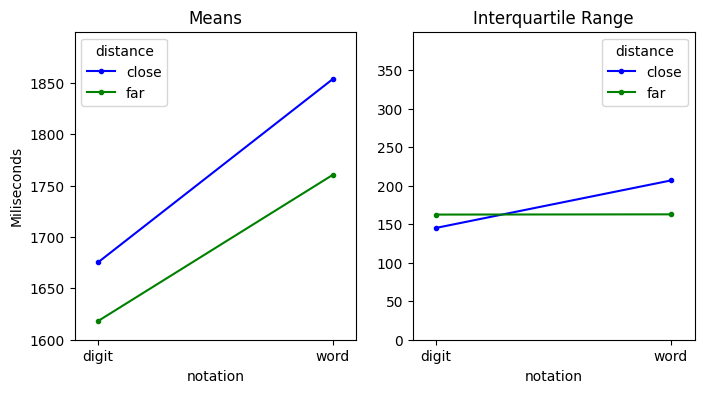

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].set_ylim([1600, 1900])
ax[0].set_yticks(range(1600, 1900, 50))

ax[1].set_ylim([0, 400])
ax[1].set_yticks(range(0, 400, 50))

ax[0].set_xticks(range(2))
ax[0].set_xticklabels(['Digits', 'Words'])
ax[1].set_xticks(range(2))
ax[1].set_xticklabels(['Digits', 'Words'])

ax[0].set_title('Means')
ax[1].set_title('Interquartile Range')

# y axis label

# interaction plot for mean
interaction_plot(mean_RT_delay_1025["notation"], mean_RT_delay_1025["distance"], mean_RT_delay_1025["rt_2_accum_mean"], ax=ax[0], colors=['blue', 'green'])

# interaction plot for interquartile range
# calculate interquartile range for each group
interquartile_range = mean_RT_delay_1025.groupby(["notation", "distance"]).rt_2_accum_mean.apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).to_frame()
interquartile_range = interquartile_range.reset_index()
interquartile_range.columns = ["notation", "distance", "interquartile_range"]
interaction_plot(interquartile_range["notation"], interquartile_range["distance"], interquartile_range["interquartile_range"], ax=ax[1], colors=['blue', 'green'])


ax[0].set_ylabel('Miliseconds')
ax[1].set_ylabel('')



plt.show()


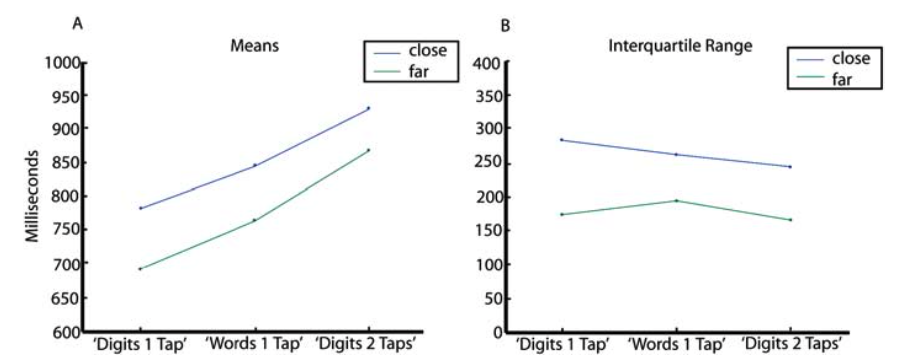

In [28]:
mean_notation_RTs = pd.DataFrame()
mean_distance_RTs = pd.DataFrame()
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        # notation
        rt1_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_1.mean())
        # rt2 in reality is delay + rt2
        rt2_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_2_accum.mean())
        mean_notation_RTs = pd.concat([mean_notation_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)
        # distance
        rt1_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_1.mean())
        rt2_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_2_accum.mean())
        mean_distance_RTs = pd.concat([mean_distance_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)

mean_notation_RTs = mean_notation_RTs.reset_index()
mean_distance_RTs = mean_distance_RTs.reset_index()

In [29]:
mean_notation_RTs

,notation,delay,rt_1,rt_2_accum
0,digit,0.0,975.933333,1320.133333
1,digit,102.5,790.875000,1101.687500
2,digit,992.5,763.425000,1621.289474
3,digit,1025.0,752.555556,1676.555556
4,word,0.0,836.500000,1318.625000
...,...,...,...,...
403,digit,1025.0,672.800000,1568.900000
404,word,0.0,746.800000,1075.277778
405,word,102.5,637.300000,1050.150000
406,word,992.5,547.500000,1725.250000


In [30]:
mean_notation_RTs.groupby(["notation", "delay"]).rt_1.mean()

notation  delay 
digit     0.0       843.882554
          102.5     867.537111
          992.5     864.638637
          1025.0    848.928467
word      0.0       888.396324
          102.5     905.499449
          992.5     888.608425
          1025.0    891.167251
Name: rt_1, dtype: float64

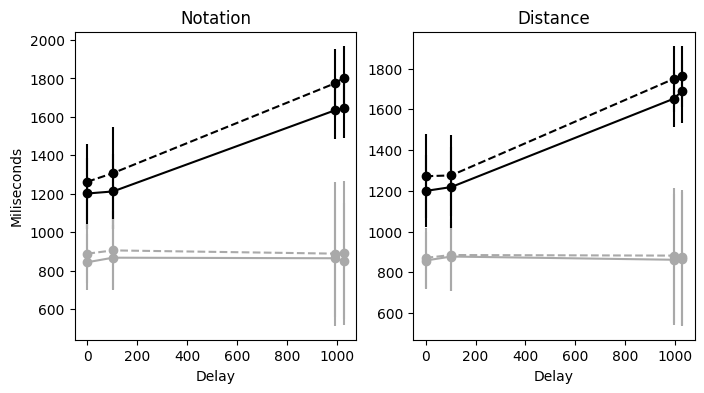

In [32]:
# show a figure with two subplots
# subplot 1: Scatter plot with mean RTs for each delay (x axis) and notation (color) 
# subplot 2: Scatter plot with mean RTs for each delay (x axis) and distance (color)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# add scatter plot with lines for mean_notation_RTs with notation as color and line properties
for notation in ["digit", "word"]:
    rt_1_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.mean().reset_index()
    rt_1_std = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.std().reset_index()

    rt_2_accum_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.mean().reset_index()
    rt_2_accum_std = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.std().reset_index()

    # scatter with error bars
    fmt_line = 'o-' if notation == "digit" else 'o--'
    
    ax[0].errorbar( rt_1_mean[rt_1_mean["notation"] == notation]["delay"], 
                    rt_1_mean[rt_1_mean["notation"] == notation]["rt_1"], 
                    yerr=rt_1_std[rt_1_std["notation"] == notation]["rt_1"], 
                    fmt=fmt_line, label=notation, color="darkgray")

    ax[0].errorbar( rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["rt_2_accum"], 
                    yerr=rt_2_accum_std[rt_2_accum_std["notation"] == notation]["rt_2_accum"], 
                    fmt=fmt_line, label=notation, color="black")

for distance in ["close", "far"]:
    rt_1_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.mean().reset_index()
    rt_1_std = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.std().reset_index()

    rt_2_accum_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.mean().reset_index()
    rt_2_accum_std = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.std().reset_index()

    # scatter with error bars
    fmt_line = 'o-' if distance == "far" else 'o--'
    
    ax[1].errorbar( rt_1_mean[rt_1_mean["distance"] == distance]["delay"], 
                    rt_1_mean[rt_1_mean["distance"] == distance]["rt_1"], 
                    yerr=rt_1_std[rt_1_std["distance"] == distance]["rt_1"], 
                    fmt=fmt_line, label=distance, color="darkgray")

    ax[1].errorbar( rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["rt_2_accum"], 
                    yerr=rt_2_accum_std[rt_2_accum_std["distance"] == distance]["rt_2_accum"], 
                    fmt=fmt_line, label=distance, color="black")
    

ax[0].set_title('Notation')
ax[0].set_ylabel('Miliseconds')
ax[0].set_xlabel('Delay')

ax[1].set_title('Distance')
ax[1].set_ylabel('')
ax[1].set_xlabel('Delay')

plt.show()

# En el gráfico de notation, las líneas punteadas son para las palabras 
# y las líneas continuas para los dígitos.

# En el gráfico de distance, las líneas punteadas son para los close.




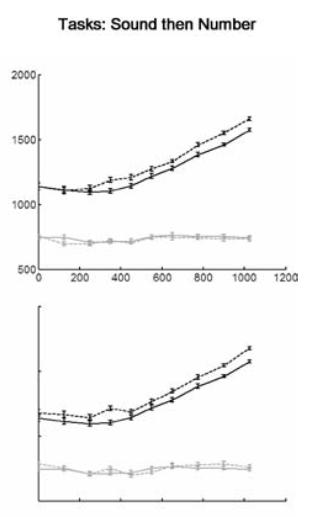

##  Figure 5

Thus, our purpose was to test the prediction of our model that the notation and response-complexity manipulations should affect the parameter $t_0$ while the distance manipulation should affect the parameter $\alpha$.

t_0, \alpha, \sigma, T 

Parameters of the mathematical model used to fit the distributions of RTs to the first task. The model we use is a simple variant of a general class of models known as random-walk models. Briefly, the model supposes a fixed delay (t_0) followed by a stochastic ac- cumulation of evidence with a fixed drift rate (\alpha) and added Gaussian noise (whose amplitude is determined by the "diffusion constant" \sigma), which stops once it hits a threshold level (T).

In [33]:
from scipy.stats import invgauss

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html